# Implement a tiny version of YOLO with DIOR dataset

## Import libraries

In [1]:
import os
import shutil
import numpy as np
from tqdm.auto import tqdm
from collections import Counter
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import cv2
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from PIL import Image
import torch.optim as optim
from torchinfo import summary
import albumentations as A
from albumentations.pytorch import ToTensorV2

/home/arch/ObjDct_Repo/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Implement YOLO architecture

In [2]:
class LinearActivation(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, t):
        return torch.pow(t, 1)

In [3]:
class TinyissimoYOLO(nn.Module):
    def __init__(self, B=2, num_classes=1, S=4):
        super(TinyissimoYOLO, self).__init__()
        
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),
            LinearActivation(),
            nn.AvgPool2d(kernel_size=2, stride=2)
        )

        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            LinearActivation(),
            nn.AvgPool2d(kernel_size=2, stride=2)
        )

        self.layer3 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            LinearActivation(),
            nn.AvgPool2d(kernel_size=2,stride = 2)
        )

        self.layer4 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            LinearActivation(),
            nn.AvgPool2d(kernel_size=2,stride = 2)
        )

        self.fclayers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128*5*5, 256),
            LinearActivation(),
            nn.Linear(256, S*S*(num_classes + 3 * B)),
        )


    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        print(x.shape)
        x = self.fclayers(x)
        
        return x


model = TinyissimoYOLO()

In [5]:
summary(model, input_size=(1, 3, 88, 88))

torch.Size([1, 128, 5, 5])


Layer (type:depth-idx)                   Output Shape              Param #
TinyissimoYOLO                           [1, 112]                  --
├─Sequential: 1-1                        [1, 16, 44, 44]           --
│    └─Conv2d: 2-1                       [1, 16, 88, 88]           448
│    └─LinearActivation: 2-2             [1, 16, 88, 88]           --
│    └─AvgPool2d: 2-3                    [1, 16, 44, 44]           --
├─Sequential: 1-2                        [1, 32, 22, 22]           --
│    └─Conv2d: 2-4                       [1, 32, 44, 44]           4,640
│    └─LinearActivation: 2-5             [1, 32, 44, 44]           --
│    └─AvgPool2d: 2-6                    [1, 32, 22, 22]           --
├─Sequential: 1-3                        [1, 64, 11, 11]           --
│    └─Conv2d: 2-7                       [1, 64, 22, 22]           18,496
│    └─LinearActivation: 2-8             [1, 64, 22, 22]           --
│    └─AvgPool2d: 2-9                    [1, 64, 11, 11]           --
├─Seque

## Utility Function

### Distance between centers

In [24]:
def euclidean_distance(center_preds, center_labels):
    """
    Calculate euclidean distance
    Parameters:
        center_preds: predictions of centers (BATCH_SIZE, 2)
        center_labels: target of centers of shape (BATCH_SIZE, 2)
    Returns:
        distance: euclidean distance for all examples
    """

    x1 = center_preds[..., 0:1]
    y1 = center_preds[..., 1:2]
    x2 = center_labels[..., 0:1]
    y2 = center_labels[..., 1:2]

    distance = torch.sqrt((x2 - x1)**2 + (y2 - y1)**2)

    return distance

### Mean Average Precision

In [25]:
def is_center_inside_bbox(center, bbox):
    """
    Check if a center (x, y) is inside a bounding box (x, y, w, h).
    Parameters:
        center (tuple): The (x, y) coordinates of the center.
        bbox (tuple): The (x, y, w, h) coordinates of the bounding box.
    Returns:
        bool: True if the center is inside the bounding box, False otherwise.
    """
    center_x, center_y = center
    bbox_x, bbox_y, bbox_w, bbox_h = bbox

    bbox_x_min = bbox_x - bbox_w / 2
    bbox_x_max = bbox_x + bbox_w / 2
    bbox_y_min = bbox_y - bbox_h / 2
    bbox_y_max = bbox_y + bbox_h / 2

    return bbox_x_min <= center_x <= bbox_x_max and bbox_y_min <= center_y <= bbox_y_max


In [26]:
def mean_average_precision(
    pred_boxes, true_boxes, num_classes=1
):
    """
    Calculates mean average precision 
    Parameters:
        pred_boxes (list): list of lists containing all bboxes with each bbox
        specified as [train_idx, class_prediction, prob_score, x_center, y_center]
        true_boxes (list): Similar as pred_boxes except all the correct ones 
        specified as [train_idx, class_label, x, y, w, h]
        num_classes (int): number of classes
    Returns:
        float: mAP value across all classes 
    """
    average_precisions = []
    epsilon = 1e-6

    for c in range(num_classes):
        detections = []
        ground_truths = []

        for detection in pred_boxes:
            if detection[1] == c:
                detections.append(detection)

        for true_box in true_boxes:
            if true_box[1] == c:
                ground_truths.append(true_box)

        amount_bboxes = Counter([gt[0] for gt in ground_truths])

        for key, val in amount_bboxes.items():
            amount_bboxes[key] = torch.zeros(val)

        detections.sort(key=lambda x: x[2], reverse=True)
        TP = torch.zeros((len(detections)))
        FP = torch.zeros((len(detections)))
        total_true_bboxes = len(ground_truths)

        if total_true_bboxes == 0:
            continue

        for detection_idx, detection in enumerate(detections):
            ground_truth_img = [
                bbox for bbox in ground_truths if bbox[0] == detection[0]
            ]

            best_match = False

            for idx, gt in enumerate(ground_truth_img):
                if is_center_inside_bbox(detection[3:5], gt[2:]):
                    best_match = True
                    best_gt_idx = idx
                    break

            if best_match:
                if amount_bboxes[detection[0]][best_gt_idx] == 0:
                    TP[detection_idx] = 1
                    amount_bboxes[detection[0]][best_gt_idx] = 1
                else:
                    FP[detection_idx] = 1
            else:
                FP[detection_idx] = 1

        TP_cumsum = torch.cumsum(TP, dim=0)
        FP_cumsum = torch.cumsum(FP, dim=0)
        recalls = TP_cumsum / (total_true_bboxes + epsilon)
        precisions = torch.divide(TP_cumsum, (TP_cumsum + FP_cumsum + epsilon))
        precisions = torch.cat((torch.tensor([1]), precisions))
        recalls = torch.cat((torch.tensor([0]), recalls))
        average_precisions.append(torch.trapz(precisions, recalls))

    return sum(average_precisions) / len(average_precisions)



### Non Max Suppression


In [27]:
def non_max_suppression(centers, threshold, distance_threshold):

    assert type(centers) == list
    # centers = [center for center in centers if center[1]> threshold]
    centers = sorted(centers, key=lambda x: x[1], reverse=True)
    centers_after_nms = []

    while centers:
        current_center = centers.pop(0)
        # centers = [
        #     center
        #     for center in centers
        #     if center[0] != current_center[0]
        #     or euclidean_distance(
        #         torch.tensor(current_center[3:5]).unsqueeze(0),
        #         torch.tensor(center[3:5]).unsqueeze(0),
        #     )
        #     > distance_threshold
        # ]

        centers_after_nms.append(current_center)
        break
        
    return centers_after_nms


### Get and convert centers

In [28]:
def get_bboxes(
    loader,
    model,
    threshold,
    distance_threshold,
    device="cuda",
):
    all_pred_centers = []
    all_true_centers = []
    all_true_boxes = []

    # make sure model is in eval before get bboxes
    model.eval()
    train_idx = 0

    for batch_idx, (x, labels, boxes_list) in enumerate(loader):
        x = x.to(device)
        labels = labels.to(device)
        
        with torch.no_grad():
            predictions = model(x)

        
        batch_size = x.shape[0]
        true_centers = cellcenters_to_centers(labels) # type: ignore
        pred_centers = cellcenters_to_centers(predictions) # type: ignore
        
        

        for idx in range(batch_size):

            boxes = boxes_list[idx].to(device)

            nms_centers= non_max_suppression(
                pred_centers[idx],
                threshold=threshold,
                distance_threshold=distance_threshold,
            )

            for center in nms_centers:
                all_pred_centers.append([train_idx] + center)

            # for center in pred_centers[idx]:
            #     if center[1] > 0:
            #         all_pred_centers.append([train_idx] + center)

            for center in true_centers[idx]:
                if center[1] > 0:
                    all_true_centers.append([train_idx] + center)

            for box in boxes:
                all_true_boxes.append([train_idx] + box.tolist())

            train_idx += 1

    model.train()
    return all_pred_centers, all_true_centers, all_true_boxes


In [29]:
def convert_cellcenters(predictions, S=4, C=1):
    """
    Converts predictions from the model to centers
    """
    predictions = predictions.to("cpu")
    batch_size = predictions.shape[0]
    predictions = predictions.reshape(batch_size, S, S, C + 6)

    centers1 = predictions[..., C + 1:C + 3]
    centers2 = predictions[..., C + 4:C + 6]
    
    scores = torch.cat(
        (predictions[..., C].unsqueeze(0), predictions[..., C + 3].unsqueeze(0)), dim=0
    )
    best_center = scores.argmax(0).unsqueeze(-1)

    best_centers = centers1 * (1 - best_center) + best_center * centers2

    # This results in a tensor with shape (batch_size, 7, 7, 1) where each element represents the index of a grid cell.
    cell_indices = torch.arange(S).repeat(batch_size, S, 1).unsqueeze(-1)
    x = 1 / S * (best_centers[..., :1] + cell_indices)
    # Permute because is used here to swap these indices to match the (x, y) convention used in the best_boxes tensor.
    # [0,1,2]->[0,0,0]
    # [0,1,2]->[1,1,1]
    # [0,1,2]->[2,2,2]
    y = 1 / S * (best_centers[..., 1:2] + cell_indices.permute(0, 2, 1, 3))
    converted_centers = torch.cat((x, y), dim=-1)
    predicted_class = predictions[..., :C].argmax(-1).unsqueeze(-1)
    best_confidence = torch.max(predictions[..., C], predictions[..., C + 3]).unsqueeze(
        -1
    )
    
    converted_preds = torch.cat(
        (predicted_class, best_confidence, converted_centers), dim=-1
    )

    return converted_preds

In [30]:
def cellcenters_to_centers(out, S=4):
    converted_pred = convert_cellcenters(out).reshape(out.shape[0], S * S, -1)
    converted_pred[..., 0] = converted_pred[..., 0].long()
    all_centers = []

    for ex_idx in range(out.shape[0]):
        centers = []
        for center_idx in range(S * S):
            centers.append([x.item() for x in converted_pred[ex_idx, center_idx, :]])
        all_centers.append(centers)
        
    return all_centers

## Create Loader of Dataset

In [31]:
class Compose(object):
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, img, centers):
        for t in self.transforms:
            img, centers = t(img), centers

        return img, centers


transform = Compose([transforms.Resize((88, 88)), transforms.ToTensor()])

In [32]:
class DiorDataset(torch.utils.data.Dataset):
    def __init__(self, root_dir, S=4, B=2, C=1, transform=None, train=True):
        self.root_dir = root_dir
        self.transform = transform
        self.S = S
        self.B = B
        self.C = C
        self.train = train

        # Determine the directory of the images and labels
        self.img_dir = os.path.join(self.root_dir, 'images')
        self.label_dir = os.path.join(self.root_dir, 'label')

        self.img_ids = os.listdir(self.img_dir)

    def __len__(self):
        return len(self.img_ids)

    def __getitem__(self, index):
        img_id = self.img_ids[index].split('.')[0]
        centers = []
        boxes = []
        # Load image
        img_path = os.path.join(self.img_dir, img_id + '.jpg')
        image = Image.open(img_path)
        image = image.convert("RGB")

        # Load labels
        label_path = os.path.join(self.label_dir, img_id + '.txt')
        with open(label_path, 'r') as f:
            for line in f.readlines():
                class_label, x, y, width, height = map(float, line.strip().split())
                centers.append([class_label, x, y])
                boxes.append([class_label, x, y, width, height])
        
        if len(boxes) > 3:
            boxes = boxes[:3]
            centers = centers[:3]

        boxes = torch.tensor(boxes)
        centers = torch.tensor(centers)        
        if self.transform:
            image, centers = self.transform(image, centers)
        # Convert To Cells
        label_matrix = torch.zeros((self.S, self.S, self.C + 3 * self.B))
        for center in centers:
            class_label, x, y = center
            class_label = int(class_label)
            i, j = int(self.S * y), int(self.S * x)
            x_cell, y_cell = self.S * x - j, self.S * y - i

            if label_matrix[i, j, self.C] == 0:
                label_matrix[i, j, self.C] = 1

                center_coordinates = torch.tensor(
                    [x_cell, y_cell]
                )

                label_matrix[i, j, self.C + 1:self.C + 3] = center_coordinates
                label_matrix[i, j, class_label] = 1
    
        #print(f"label_matrix shape: {label_matrix.shape}")

        return image, label_matrix , boxes

## YOLO Loss

From original paper: 
>   YOLO predicts multiple bounding boxes per grid cell. At training time we only want one bounding box predictor to be responsible for each object. We assign one predictor to be “responsible” for predicting an object based on which prediction has the highest current IOU with the ground truth. This leads to specialization between the bounding box predictors.
Each predictor gets better at predicting certain sizes, aspect ratios, or classes of object, improving overall recall. 

$$
\begin{gathered}
\lambda_{\text {coord }} \sum_{i=0}^{S^2} \sum_{j=0}^B \mathbb{1}_{i j}^{\text {obj }}\left[\left(x_i-\hat{x}_i\right)^2+\left(y_i-\hat{y}_i\right)^2\right] \\
+\lambda_{\text {coord }} \sum_{i=0}^{S^2} \sum_{j=0}^B \mathbb{1}_{i j}^{\text {obj }}\left[\left(\sqrt{w_i}-\sqrt{\hat{w}_i}\right)^2+\left(\sqrt{h_i}-\sqrt{\hat{h}_i}\right)^2\right] \\
+\sum_{i=0}^{S^2} \sum_{j=0}^B \mathbb{1}_{i j}^{\text {obj }}\left(C_i-\hat{C}_i\right)^2 \\
+\lambda_{\text {noobj }} \sum_{i=0}^{S^2} \sum_{j=0}^B \mathbb{1}_{i j}^{\text {noobj }}\left(C_i-\hat{C}_i\right)^2 \\
+\sum_{i=0}^{S^2} \mathbb{1}_i^{\text {obj }} \sum_{c \in \text { classes }}\left(p_i(c)-\hat{p}_i(c)\right)^2
\end{gathered}
$$

During training we optimize the following, multi-part where $ 1_{obj}^i $ denotes if object appears in cell **i** and $1_{obj}^{ij}$ denotes that the **j**  bounding box predictor in cell i is “responsible” for that prediction.

In every image many grid cells do not contain any object. This pushes the “confidence” scores of those cells towards zero, often overpowering the gradient from cells that do contain objects. This can lead to model instability, as the model may prioritize learning to predict empty cells rather than focusing on correctly detecting objects in cells containing them, causing training to diverge early on. To remedy this, we increase the loss from bounding box coordinate predictions and decrease the loss from confidence predictions for boxes that don’t contain objects. We use two parameters, $\lambda_{coord}$ and $\lambda_{noobj}$  to accomplish this.

Note that the loss function only penalizes classification error if an object is present in that grid cell (hence the conditional class probability discussed earlier). It also only penalizes bounding box coordinate error if that predictor is “responsible” for the ground truth box (i.e. has the highest
IOU of any predictor in that grid cell).

In [33]:
class YoloLoss(nn.Module):
    """
    Calculate the loss for yolo (v1) model
    """

    def __init__(self, S=4, B=2, C=1):
        super(YoloLoss, self).__init__()
        self.mse = nn.MSELoss(reduction="sum")

        """
        S is split size of image (in paper 7),
        B is number of boxes (in paper 2),
        C is number of classes (in paper 20, in dataset 3),
        """
        self.S = S
        self.B = B
        self.C = C

        # These are from Yolo paper, signifying how much we should
        # pay loss for no object (noobj) and the box coordinates (coord)
        self.lambda_noobj = 0.5
        self.lambda_coord = 5

    def forward(self, predictions, target):
        # predictions are shaped (BATCH_SIZE, S*S(C+B*3) when inputted
        predictions = predictions.reshape(-1, self.S, self.S, self.C + self.B * 3)
        # Calculate IoU for the two predicted bounding boxes with target bbox
        iou_c1 = euclidean_distance(predictions[..., self.C + 1:self.C + 3], target[..., self.C + 1:self.C + 3])
        iou_c2 = euclidean_distance(predictions[..., self.C + 4:self.C + 6], target[..., self.C + 1:self.C + 3])
        ious = torch.cat([iou_c1.unsqueeze(0), iou_c2.unsqueeze(0)], dim=0)
        # Take the box with highest IoU out of the two prediction
        # Note that bestbox will be indices of 0, 1 for which bbox was best
        iou_maxes, bestcenter = torch.max(ious, dim=0)
        exists_center = target[..., self.C].unsqueeze(3)  # in paper this is Iobj_i
        
        # ======================== #
        #   FOR CENTER COORDINATES #
        # ======================== #

        # Set boxes with no object in them to 0. We only take out one of the two 
        # predictions, which is the one with highest Iou calculated previously.

        center_predictions = exists_center * (
            (
                bestcenter * predictions[..., self.C + 4:self.C + 6]
                + (1 - bestcenter) * predictions[..., self.C + 1:self.C + 3]
            )
        )
        center_targets = exists_center * target[..., self.C + 1:self.C + 3]

        center_loss = self.mse(
            torch.flatten(center_predictions, end_dim=-2),
            torch.flatten(center_targets, end_dim=-2),
        )

        # ==================== #
        #   FOR OBJECT LOSS    #
        # ==================== #

        # pred_box is the confidence score for the bbox with highest IoU
        pred_center = (
            bestcenter * predictions[..., self.C + 3:self.C + 4] + (1 - bestcenter) * predictions[..., self.C:self.C + 1]
        )

        object_loss = self.mse(
            torch.flatten(exists_center * pred_center),
            torch.flatten(exists_center * target[..., self.C:self.C + 1]),
        )

        # ======================= #
        #   FOR NO OBJECT LOSS    #
        # ======================= #

        no_object_loss = self.mse(
            torch.flatten((1 - exists_center) * predictions[..., self.C:self.C + 1], start_dim=1),
            torch.flatten((1 - exists_center) * target[..., self.C:self.C + 1], start_dim=1),
        )

        no_object_loss += self.mse(
            torch.flatten((1 - exists_center) * predictions[..., self.C + 3:self.C + 4], start_dim=1),
            torch.flatten((1 - exists_center) * target[..., self.C:self.C + 1], start_dim=1)
        )

        # ================== #
        #   FOR CLASS LOSS   #
        # ================== #

        class_loss = self.mse(
            torch.flatten(exists_center * predictions[..., :self.C], end_dim=-2,),
            torch.flatten(exists_center * target[..., :self.C], end_dim=-2,),
        )

        loss = (
            self.lambda_coord * center_loss  # first two rows in paper
            + object_loss  # third row in paper
            + self.lambda_noobj * no_object_loss  # forth row
            + class_loss  # fifth row
        )

        return loss

## Training

In [34]:
LEARNING_RATE = 2e-5
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
BATCH_SIZE = 32 # 64 in original paper but resource exhausted error otherwise.
WEIGHT_DECAY = 0
EPOCHS = 100
LOAD_MODEL = False
LOAD_MODEL_FILE = "fomo.pth"

In [35]:
def train_fn(train_loader, model, optimizer, loss_fn):
    loop = tqdm(train_loader, leave=True)
    mean_loss = []
    
    for batch_idx, (x, y,boxes) in enumerate(loop):
        x = x.to(DEVICE)
        y = y.to(DEVICE)
        out = model(x)
        loss = loss_fn(out, y)
        mean_loss.append(loss.item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        loop.set_postfix(loss = loss.item())
        
    print(f"Mean loss was {sum(mean_loss) / len(mean_loss)}")

### Combine all

In [36]:
def collate_fn(batch):
    images = []
    label_matrices = []
    boxes_list = []
    for item in batch:
        images.append(item[0])
        label_matrices.append(item[1])
        boxes_list.append(item[2])
    images = torch.stack(images)
    label_matrices = torch.stack(label_matrices)
    return images, label_matrices, boxes_list

In [37]:
from torch.utils.data import random_split


files_dir = 'one_class_data'
model = TinyissimoYOLO().to(DEVICE)
optimizer = optim.Adam(
    model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY
)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer, factor=0.1, patience=3, mode='max', verbose=True)
loss_fn = YoloLoss()


train_dataset = DiorDataset(
    root_dir=files_dir,
    transform=transform,
    train=True
)


# Define the length of the training set
train_len = int(0.8 * len(train_dataset))

# Define the length of the test set
test_len = len(train_dataset) - train_len

# Split the dataset
train_dataset, test_dataset = random_split(train_dataset, [train_len, test_len])

# Now you can create your DataLoaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=False, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, drop_last=False, collate_fn=collate_fn)

/home/arch/ObjDct_Repo/.venv/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


In [38]:
for epoch in range(EPOCHS):
    print(f"Epoch {epoch + 1}/{EPOCHS}")
    train_fn(train_loader, model, optimizer, loss_fn)
    pred_boxes, target_boxes, real_boxes = get_bboxes(
        train_loader, model, threshold=0.4, distance_threshold=0.1
    )
    mAP = mean_average_precision(pred_boxes, real_boxes)
    print(f"mAP: {mAP}")

Epoch 1/100


100%|██████████| 28/28 [00:03<00:00,  8.58it/s, loss=101]


Mean loss was 174.22255870274134
mAP: 0.09050809592008591
Epoch 2/100


100%|██████████| 28/28 [00:02<00:00,  9.52it/s, loss=59.3]


Mean loss was 104.30295780726841
mAP: 0.504238486289978
Epoch 3/100


100%|██████████| 28/28 [00:02<00:00,  9.53it/s, loss=40.5]


Mean loss was 72.09068502698626
mAP: 0.520530641078949
Epoch 4/100


100%|██████████| 28/28 [00:02<00:00,  9.61it/s, loss=44]  


Mean loss was 63.390579632350374
mAP: 0.5111578702926636
Epoch 5/100


100%|██████████| 28/28 [00:02<00:00,  9.62it/s, loss=48.4]


Mean loss was 58.91898659297398
mAP: 0.5166173577308655
Epoch 6/100


100%|██████████| 28/28 [00:02<00:00,  9.57it/s, loss=43]  


Mean loss was 56.42841270991734
mAP: 0.5126722455024719
Epoch 7/100


100%|██████████| 28/28 [00:02<00:00,  9.59it/s, loss=39.1]


Mean loss was 54.761153084891184
mAP: 0.5141769647598267
Epoch 8/100


100%|██████████| 28/28 [00:02<00:00,  9.56it/s, loss=46.5]


Mean loss was 53.46169063023159
mAP: 0.5127039551734924
Epoch 9/100


100%|██████████| 28/28 [00:02<00:00,  9.50it/s, loss=35]  


Mean loss was 52.668761934552876
mAP: 0.5240744352340698
Epoch 10/100


100%|██████████| 28/28 [00:02<00:00,  9.57it/s, loss=40.1]


Mean loss was 52.20018359592983
mAP: 0.5201159119606018
Epoch 11/100


100%|██████████| 28/28 [00:02<00:00,  9.42it/s, loss=32.2]


Mean loss was 51.49714265550886
mAP: 0.5200673937797546
Epoch 12/100


100%|██████████| 28/28 [00:02<00:00,  9.48it/s, loss=41.4]


Mean loss was 51.21327917916434
mAP: 0.519405722618103
Epoch 13/100


100%|██████████| 28/28 [00:02<00:00,  9.45it/s, loss=50.8]


Mean loss was 51.003764969961985
mAP: 0.5225948691368103
Epoch 14/100


100%|██████████| 28/28 [00:02<00:00,  9.37it/s, loss=39]  


Mean loss was 50.547630310058594
mAP: 0.5235791206359863
Epoch 15/100


100%|██████████| 28/28 [00:02<00:00,  9.47it/s, loss=45]  


Mean loss was 50.25765677860805
mAP: 0.5292503237724304
Epoch 16/100


100%|██████████| 28/28 [00:02<00:00,  9.44it/s, loss=51.1]


Mean loss was 50.123277936662944
mAP: 0.5330635905265808
Epoch 17/100


100%|██████████| 28/28 [00:02<00:00,  9.42it/s, loss=48]  


Mean loss was 49.904118401663645
mAP: 0.536175012588501
Epoch 18/100


100%|██████████| 28/28 [00:02<00:00,  9.46it/s, loss=30.2]


Mean loss was 49.778352056230815
mAP: 0.5442169308662415
Epoch 19/100


100%|██████████| 28/28 [00:02<00:00,  9.47it/s, loss=34]  


Mean loss was 49.66613238198416
mAP: 0.5412673950195312
Epoch 20/100


100%|██████████| 28/28 [00:02<00:00,  9.43it/s, loss=33.8]


Mean loss was 49.598189217703684
mAP: 0.5507544875144958
Epoch 21/100


100%|██████████| 28/28 [00:02<00:00,  9.48it/s, loss=45.3]


Mean loss was 49.634721347263884
mAP: 0.5411509871482849
Epoch 22/100


100%|██████████| 28/28 [00:02<00:00,  9.52it/s, loss=36.2]


Mean loss was 49.57550062452044
mAP: 0.5464120507240295
Epoch 23/100


100%|██████████| 28/28 [00:02<00:00,  9.52it/s, loss=41.4]


Mean loss was 49.419501304626465
mAP: 0.5570517778396606
Epoch 24/100


100%|██████████| 28/28 [00:02<00:00,  9.44it/s, loss=37.8]


Mean loss was 49.30964796883719
mAP: 0.5428768396377563
Epoch 25/100


100%|██████████| 28/28 [00:02<00:00,  9.47it/s, loss=35]  


Mean loss was 49.4200645174299
mAP: 0.5500411987304688
Epoch 26/100


100%|██████████| 28/28 [00:02<00:00,  9.46it/s, loss=31]  


Mean loss was 49.323496614183696
mAP: 0.5519428849220276
Epoch 27/100


100%|██████████| 28/28 [00:02<00:00,  9.44it/s, loss=43.6]


Mean loss was 49.27685410635812
mAP: 0.5519179701805115
Epoch 28/100


100%|██████████| 28/28 [00:02<00:00,  9.39it/s, loss=40.1]


Mean loss was 49.20636054447719
mAP: 0.5478022694587708
Epoch 29/100


100%|██████████| 28/28 [00:02<00:00,  9.42it/s, loss=26.6]


Mean loss was 49.10495185852051
mAP: 0.5453470349311829
Epoch 30/100


100%|██████████| 28/28 [00:02<00:00,  9.50it/s, loss=32.3]


Mean loss was 49.12581198556082
mAP: 0.5530819892883301
Epoch 31/100


100%|██████████| 28/28 [00:02<00:00,  9.46it/s, loss=37.9]


Mean loss was 49.096884318760466
mAP: 0.5495049357414246
Epoch 32/100


100%|██████████| 28/28 [00:02<00:00,  9.47it/s, loss=35.7]


Mean loss was 49.267354420253206
mAP: 0.5565057992935181
Epoch 33/100


100%|██████████| 28/28 [00:02<00:00,  9.55it/s, loss=34.9]


Mean loss was 49.09332806723459
mAP: 0.5510268211364746
Epoch 34/100


100%|██████████| 28/28 [00:02<00:00,  9.57it/s, loss=41.6]


Mean loss was 48.96155275617327
mAP: 0.5528923273086548
Epoch 35/100


100%|██████████| 28/28 [00:02<00:00,  9.56it/s, loss=34.2]


Mean loss was 49.03038311004639
mAP: 0.5523631572723389
Epoch 36/100


100%|██████████| 28/28 [00:02<00:00,  9.61it/s, loss=40.3]


Mean loss was 48.76801463535854
mAP: 0.5575427412986755
Epoch 37/100


100%|██████████| 28/28 [00:02<00:00,  9.59it/s, loss=44.3]


Mean loss was 49.02766881670271
mAP: 0.5576030015945435
Epoch 38/100


100%|██████████| 28/28 [00:02<00:00,  9.53it/s, loss=39.6]


Mean loss was 49.177855355399
mAP: 0.5576362013816833
Epoch 39/100


100%|██████████| 28/28 [00:02<00:00,  9.59it/s, loss=38.3]


Mean loss was 49.027865409851074
mAP: 0.5558281540870667
Epoch 40/100


100%|██████████| 28/28 [00:02<00:00,  9.57it/s, loss=32]  


Mean loss was 49.000126702444895
mAP: 0.5619609355926514
Epoch 41/100


100%|██████████| 28/28 [00:02<00:00,  9.53it/s, loss=43.2]


Mean loss was 49.133118629455566
mAP: 0.5520700812339783
Epoch 42/100


100%|██████████| 28/28 [00:02<00:00,  9.47it/s, loss=38.7]


Mean loss was 48.706336293901714
mAP: 0.5553754568099976
Epoch 43/100


100%|██████████| 28/28 [00:02<00:00,  9.57it/s, loss=32.7]


Mean loss was 48.79246439252581
mAP: 0.5645220875740051
Epoch 44/100


100%|██████████| 28/28 [00:02<00:00,  9.50it/s, loss=42.4]


Mean loss was 48.61051164354597
mAP: 0.5597938895225525
Epoch 45/100


100%|██████████| 28/28 [00:02<00:00,  9.51it/s, loss=41]  


Mean loss was 48.5207576751709
mAP: 0.5585213899612427
Epoch 46/100


100%|██████████| 28/28 [00:02<00:00,  9.51it/s, loss=49.7]


Mean loss was 48.53167833600725
mAP: 0.5597553253173828
Epoch 47/100


100%|██████████| 28/28 [00:02<00:00,  9.58it/s, loss=35]  


Mean loss was 48.641881125313894
mAP: 0.5514532327651978
Epoch 48/100


100%|██████████| 28/28 [00:02<00:00,  9.55it/s, loss=33]  


Mean loss was 48.639584405081614
mAP: 0.5550190806388855
Epoch 49/100


100%|██████████| 28/28 [00:02<00:00,  9.53it/s, loss=43.6]


Mean loss was 48.57708631243025
mAP: 0.5555254220962524
Epoch 50/100


100%|██████████| 28/28 [00:02<00:00,  9.41it/s, loss=36.1]


Mean loss was 48.482461384364534
mAP: 0.5466006994247437
Epoch 51/100


100%|██████████| 28/28 [00:02<00:00,  9.43it/s, loss=33.2]


Mean loss was 48.25813743046352
mAP: 0.5692135691642761
Epoch 52/100


100%|██████████| 28/28 [00:02<00:00,  9.46it/s, loss=32.1]


Mean loss was 48.2328006199428
mAP: 0.557380735874176
Epoch 53/100


100%|██████████| 28/28 [00:02<00:00,  9.36it/s, loss=34.2]


Mean loss was 48.34309468950544
mAP: 0.5582126975059509
Epoch 54/100


100%|██████████| 28/28 [00:02<00:00,  9.43it/s, loss=29]  


Mean loss was 48.44871759414673
mAP: 0.5522138476371765
Epoch 55/100


100%|██████████| 28/28 [00:02<00:00,  9.53it/s, loss=36.2]


Mean loss was 48.21078600202288
mAP: 0.5534117221832275
Epoch 56/100


100%|██████████| 28/28 [00:02<00:00,  9.54it/s, loss=37.2]


Mean loss was 48.219746589660645
mAP: 0.5481794476509094
Epoch 57/100


100%|██████████| 28/28 [00:02<00:00,  9.47it/s, loss=46.6]


Mean loss was 48.185307775224956
mAP: 0.5462011694908142
Epoch 58/100


100%|██████████| 28/28 [00:02<00:00,  9.50it/s, loss=42.6]


Mean loss was 48.27018765040806
mAP: 0.5530688166618347
Epoch 59/100


100%|██████████| 28/28 [00:02<00:00,  9.53it/s, loss=42]  


Mean loss was 47.993404797145296
mAP: 0.562818706035614
Epoch 60/100


100%|██████████| 28/28 [00:02<00:00,  9.40it/s, loss=40]  


Mean loss was 48.04655006953648
mAP: 0.5582764744758606
Epoch 61/100


100%|██████████| 28/28 [00:02<00:00,  9.46it/s, loss=36.6]


Mean loss was 47.80715669904436
mAP: 0.5460052490234375
Epoch 62/100


100%|██████████| 28/28 [00:02<00:00,  9.35it/s, loss=39.4]


Mean loss was 47.91867882864816
mAP: 0.5449930429458618
Epoch 63/100


100%|██████████| 28/28 [00:02<00:00,  9.46it/s, loss=39.5]


Mean loss was 47.976985931396484
mAP: 0.5593197345733643
Epoch 64/100


100%|██████████| 28/28 [00:02<00:00,  9.46it/s, loss=43.2]


Mean loss was 47.84378269740513
mAP: 0.543369710445404
Epoch 65/100


100%|██████████| 28/28 [00:02<00:00,  9.44it/s, loss=29.5]


Mean loss was 47.70293058667864
mAP: 0.5584465265274048
Epoch 66/100


100%|██████████| 28/28 [00:02<00:00,  9.49it/s, loss=40.3]


Mean loss was 47.800165448869976
mAP: 0.5539671182632446
Epoch 67/100


100%|██████████| 28/28 [00:02<00:00,  9.37it/s, loss=39.9]


Mean loss was 47.64272553580148
mAP: 0.5571547746658325
Epoch 68/100


100%|██████████| 28/28 [00:02<00:00,  9.51it/s, loss=33.6]


Mean loss was 47.67733751024519
mAP: 0.5525665879249573
Epoch 69/100


100%|██████████| 28/28 [00:02<00:00,  9.45it/s, loss=32.9]


Mean loss was 47.70797484261649
mAP: 0.559015154838562
Epoch 70/100


100%|██████████| 28/28 [00:02<00:00,  9.44it/s, loss=41.8]


Mean loss was 47.53396538325718
mAP: 0.5525856614112854
Epoch 71/100


100%|██████████| 28/28 [00:02<00:00,  9.53it/s, loss=40.9]


Mean loss was 47.48660959516253
mAP: 0.5595557689666748
Epoch 72/100


100%|██████████| 28/28 [00:02<00:00,  9.52it/s, loss=43.6]


Mean loss was 47.586608614240376
mAP: 0.5498638153076172
Epoch 73/100


100%|██████████| 28/28 [00:02<00:00,  9.52it/s, loss=30.4]


Mean loss was 47.733871596200125
mAP: 0.5595291256904602
Epoch 74/100


100%|██████████| 28/28 [00:02<00:00,  9.50it/s, loss=32.7]


Mean loss was 47.791520254952566
mAP: 0.5497651696205139
Epoch 75/100


100%|██████████| 28/28 [00:02<00:00,  9.48it/s, loss=31.2]


Mean loss was 47.8394513130188
mAP: 0.546882152557373
Epoch 76/100


100%|██████████| 28/28 [00:02<00:00,  9.49it/s, loss=37.7]


Mean loss was 47.319455691746306
mAP: 0.5600360631942749
Epoch 77/100


100%|██████████| 28/28 [00:02<00:00,  9.50it/s, loss=38.5]


Mean loss was 47.333993911743164
mAP: 0.5584977865219116
Epoch 78/100


100%|██████████| 28/28 [00:02<00:00,  9.53it/s, loss=33.6]


Mean loss was 47.201391083853586
mAP: 0.5607253313064575
Epoch 79/100


100%|██████████| 28/28 [00:02<00:00,  9.49it/s, loss=39.7]


Mean loss was 47.22560841696603
mAP: 0.5581804513931274
Epoch 80/100


100%|██████████| 28/28 [00:02<00:00,  9.46it/s, loss=38]  


Mean loss was 47.3958922794887
mAP: 0.5496358275413513
Epoch 81/100


100%|██████████| 28/28 [00:02<00:00,  9.48it/s, loss=38.6]


Mean loss was 47.49620723724365
mAP: 0.5558828115463257
Epoch 82/100


100%|██████████| 28/28 [00:02<00:00,  9.48it/s, loss=35.6]


Mean loss was 47.238137926374165
mAP: 0.5567349195480347
Epoch 83/100


100%|██████████| 28/28 [00:02<00:00,  9.45it/s, loss=29.5]


Mean loss was 47.32838944026402
mAP: 0.559733510017395
Epoch 84/100


100%|██████████| 28/28 [00:02<00:00,  9.46it/s, loss=41.8]


Mean loss was 47.32177816118513
mAP: 0.5590006709098816
Epoch 85/100


100%|██████████| 28/28 [00:02<00:00,  9.51it/s, loss=39]  


Mean loss was 46.99934836796352
mAP: 0.5473154187202454
Epoch 86/100


100%|██████████| 28/28 [00:02<00:00,  9.39it/s, loss=31.8]


Mean loss was 46.98408957890102
mAP: 0.5508463382720947
Epoch 87/100


100%|██████████| 28/28 [00:02<00:00,  9.52it/s, loss=27.8]


Mean loss was 46.969397272382466
mAP: 0.5597578287124634
Epoch 88/100


100%|██████████| 28/28 [00:02<00:00,  9.49it/s, loss=37.4]


Mean loss was 46.9910113470895
mAP: 0.5440802574157715
Epoch 89/100


100%|██████████| 28/28 [00:02<00:00,  9.45it/s, loss=37.2]


Mean loss was 46.9229929787772
mAP: 0.5611598491668701
Epoch 90/100


100%|██████████| 28/28 [00:02<00:00,  9.39it/s, loss=31.6]


Mean loss was 46.80109773363386
mAP: 0.5486170053482056
Epoch 91/100


100%|██████████| 28/28 [00:02<00:00,  9.44it/s, loss=33.6]


Mean loss was 46.814676829746794
mAP: 0.5461055636405945
Epoch 92/100


100%|██████████| 28/28 [00:02<00:00,  9.43it/s, loss=46.6]


Mean loss was 46.67426054818289
mAP: 0.5607511401176453
Epoch 93/100


100%|██████████| 28/28 [00:02<00:00,  9.47it/s, loss=42.4]


Mean loss was 46.72469793047224
mAP: 0.554796040058136
Epoch 94/100


100%|██████████| 28/28 [00:02<00:00,  9.42it/s, loss=43.3]


Mean loss was 46.65267549242292
mAP: 0.5560261011123657
Epoch 95/100


100%|██████████| 28/28 [00:02<00:00,  9.44it/s, loss=34.2]


Mean loss was 46.70555441720145
mAP: 0.5561373829841614
Epoch 96/100


100%|██████████| 28/28 [00:02<00:00,  9.49it/s, loss=33.1]


Mean loss was 46.609759194510325
mAP: 0.5496708750724792
Epoch 97/100


100%|██████████| 28/28 [00:02<00:00,  9.50it/s, loss=40.9]


Mean loss was 46.56198024749756
mAP: 0.5554682016372681
Epoch 98/100


100%|██████████| 28/28 [00:02<00:00,  9.46it/s, loss=38.1]


Mean loss was 46.52369253976004
mAP: 0.5589553117752075
Epoch 99/100


100%|██████████| 28/28 [00:02<00:00,  9.48it/s, loss=33]  


Mean loss was 46.39498424530029
mAP: 0.5624595284461975
Epoch 100/100


100%|██████████| 28/28 [00:02<00:00,  9.54it/s, loss=39.2]


Mean loss was 46.379413332257954
mAP: 0.5607389807701111


In [39]:
len(pred_boxes), len(real_boxes)

(889, 1090)

In [40]:
real_boxes[0]

[0,
 0.0,
 0.37599998712539673,
 0.38288289308547974,
 0.7480000257492065,
 0.6576576828956604]

In [41]:
target_boxes[0]

[0, 0.0, 1.0, 0.37599998712539673, 0.38288289308547974]

In [42]:
torch.save(model.state_dict(), "fomo.pth")

## Testing

### Load test set

### Load model and make inference

In [43]:

checkpoint = torch.load("fomo.pth")
# Load the state dictionary from the .pth file

# Load the state dictionary into the model
model.load_state_dict(checkpoint)

# Ensure the model is in evaluation mode
model.eval()


TinyissimoYOLO(
  (layer1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): LinearActivation()
    (2): AvgPool2d(kernel_size=2, stride=2, padding=0)
  )
  (layer2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): LinearActivation()
    (2): AvgPool2d(kernel_size=2, stride=2, padding=0)
  )
  (layer3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): LinearActivation()
    (2): AvgPool2d(kernel_size=2, stride=2, padding=0)
  )
  (layer4): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): LinearActivation()
    (2): AvgPool2d(kernel_size=2, stride=2, padding=0)
  )
  (fclayers): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=3200, out_features=256, bias=True)
    (2): LinearActivation()
    (3): Linear(in_features=256, out_features=112, bias=True)
  )
)

In [44]:
with torch.no_grad():
    pred_boxes, target_boxes, real_boxes = get_bboxes(
        test_loader, model, threshold = 0.4, distance_threshold=0.1
    )
    mAP = mean_average_precision(pred_boxes, real_boxes)
    print(f"mAP: {mAP}")

mAP: 0.5647098422050476


In [45]:
def plot_centers(idx, pred_centers, target_centers):
    values = test_dataset[idx]
    image = values[0]
    image = image.permute(1, 2, 0).to("cpu")
    
    image = np.array(image)
    height, width, _ = image.shape
    p_centers = []
    t_centers = []
    for center in pred_centers:
        if center[0] == idx:
            p_centers.append(center[1:])
    
    for center in target_centers:
        if center[0] == idx:
            t_centers.append(center[1:])
    

    fig, ax = plt.subplots()
    ax.imshow(image)
    
    for center in p_centers:
        rect = patches.Rectangle(
            (center[2] * width , center[3] * height),
            1,
            1,
            linewidth=5,
            edgecolor="r",
            facecolor="none",
        )
        ax.add_patch(rect)

    # Create a Rectangle patch
    for boxes in t_centers:
        class_label = int(boxes[0])
        box = boxes[1:]
        assert len(box) == 4, "Got more values than in x, y, w, h, in a box!"
        upper_left_x = box[0] - box[2] / 2
        upper_left_y = box[1] - box[3] / 2
        rect = patches.Rectangle(
            (upper_left_x * width, upper_left_y * height),
            box[2] * width,
            box[3] * height,
            linewidth=1,
            edgecolor="r",
            facecolor="none",
        )
        # Add the patch to the Axes
        ax.add_patch(rect)
        
        # Add class label text
        ax.text(upper_left_x * width, upper_left_y * height, str(class_label), color='r', fontsize=10, verticalalignment='bottom')

    
    plt.show()


In [46]:
print(len(pred_boxes))

223


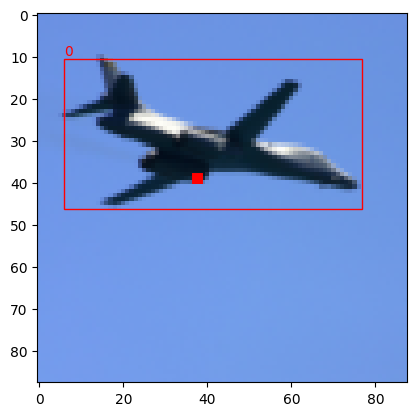

In [47]:
plot_centers(1, pred_boxes, real_boxes)

In red predicted, green true

In [ ]:
sample = torch.rand(1, 3, 256, 256).to(DEVICE)
model.eval()
output = model(sample)
print(output.shape)

In [ ]:

# Set the path to save the ONNX model
onnx_model_path = "fomo.onnx"

# Export the model to ONNX format
torch.onnx.export(model, sample, onnx_model_path)


# PYHELAYERS

## Select a subset of plain samples from test set

In [ ]:
test_img_list=[]
test_label_list=[]
for values in test_dataset:
    image = values[0]
    label = values[1]
    test_img_list.append(image)
    test_label_list.append(label)
    if len(test_img_list)==1:
        break

test_img_array = np.array(test_img_list)
test_label_array = np.array(test_label_list)
# test_img_array = test_img_array[:11728]
# test_label_array = test_label_array[:11728]
# test_img_array = test_img_array.reshape(733,16,3,64,64)
# test_label_array = test_label_array.reshape(733,16,7,7,30)
print(test_img_array.shape)
print(test_label_array.shape)

## Initialize he scheme

In [ ]:
import pyhelayers
import utilshe

utilshe.verify_memory()

print('Misc. initalizations')

In [ ]:
context = pyhelayers.DefaultContext()
print('HE context ready')

In [ ]:

nnp = pyhelayers.NeuralNetPlain()

In [ ]:
hyper_params = pyhelayers.PlainModelHyperParams()
nnp.init_from_files(hyper_params, ["fomo.onnx"])


In [ ]:
he_run_req = pyhelayers.HeRunRequirements()
he_run_req.set_he_context_options([pyhelayers.DefaultContext()])
he_run_req.optimize_for_batch_size(1)

profile = pyhelayers.HeModel.compile(nnp, he_run_req)
batch_size = profile.get_optimal_batch_size()
print('Profile ready. Batch size=',batch_size)

In [ ]:
profile.get_he_config_requirement()

In [ ]:
context = pyhelayers.HeModel.create_context(profile)
print('HE context initalized')

In [ ]:
context.get_scheme_name()

In [ ]:
context.get_default_scale()

In [ ]:
# context.get_library_name()

In [ ]:
# context.has_secret_key()

In [ ]:
# context.save_secret_key_to_file('secret_key.txt')

In [ ]:
nn = pyhelayers.NeuralNet(context)
nn.encode_encrypt(nnp, profile)
print('Encrypted network ready')

In [ ]:
plain_samples, labels = utilshe.extract_batch(test_img_array, test_label_array, batch_size, 0)

print('Batch of size',batch_size,'loaded')

In [ ]:
print(plain_samples.shape)
print(plain_samples.dtype)

In [ ]:
iop = nn.create_io_processor()
samples = pyhelayers.EncryptedData(context)
iop.encode_encrypt_inputs_for_predict(samples, [plain_samples])
print('Test data encrypted')

## Make prediction on encrypted data

In [ ]:
utilshe.start_timer()

predictions = pyhelayers.EncryptedData(context)
nn.predict(predictions, samples)

duration=utilshe.end_timer('predict')
utilshe.report_duration('predict per sample',duration/batch_size)

In [ ]:
plain_predictions_aHE = iop.decrypt_decode_output(predictions)
print(f"plain prediction shape after HE: {plain_predictions_aHE.shape}")

In [ ]:
type(plain_predictions_aHE)

In [ ]:
# ## In case I have test samples > batch size
# plain_predictions_aHE = plain_predictions_aHE.reshape(,1470)

## Evaluate prediction with HE

In [ ]:
plain_predictions_bHE=[]
for sample in test_img_array:
    tensor_sample = torch.tensor(sample).unsqueeze(0)
    output = model(tensor_sample)
    output = output.detach().numpy()
    plain_predictions_bHE.append(output)
plain_predictions_bHE = np.array(plain_predictions_bHE)
plain_predictions_bHE = plain_predictions_bHE.reshape(1, 441)
print(f"plain prediction shape before HE: {plain_predictions_bHE.shape}")


In [ ]:

# Compute the absolute differences between plain prediction before and after HE
differences = np.abs(plain_predictions_bHE - plain_predictions_aHE)

# Compute relevant statistics
mean_difference = np.mean(differences)
max_difference = np.max(differences)
min_difference = np.min(differences)
std_difference = np.std(differences)

print(f"Mean difference: {mean_difference}")
print(f"Max difference: {max_difference}")
print(f"Min difference: {min_difference}")
print(f"Std difference: {std_difference}")


### Convert prediction in bounding boxes

In [ ]:
def get_bboxes_from_prediction(
    predictions,
    test_image_array,
    iou_threshold,
    threshold,
):
    all_pred_boxes = []

    
    train_idx = 0

    bboxes = cellboxes_to_boxes(predictions)

    for idx in range(len(test_image_array)):
        image = test_image_array[idx]

        nms_boxes = non_max_suppression(
            bboxes[idx],
            iou_threshold=iou_threshold,
            threshold=threshold,
        )

        # Activate only for test
        if  idx == 0:
            plot_image(image.permute(1,2,0).to("cpu"), nms_boxes)

        for nms_box in nms_boxes:
            all_pred_boxes.append([train_idx] + nms_box)

        

        train_idx += 1

    return all_pred_boxes


In [ ]:
tensor_predaHE = torch.tensor(plain_predictions_aHE)
tensor_predbHE = torch.tensor(plain_predictions_bHE)
tensor_imgs = torch.tensor(test_img_array)

print("Prediction before HE")
bboxes_aHE = get_bboxes_from_prediction(tensor_predbHE, tensor_imgs, iou_threshold=0.5, threshold=0.4)

print("Prediction after HE")
bboxes_bHE = get_bboxes_from_prediction(tensor_predaHE, tensor_imgs, iou_threshold=0.5, threshold=0.4)